# Setup

Realize o setup para inicializar as variáveis e funções essenciais do notebook

## Instalações

In [1]:
!pip install tensorflow==2.1.0

## Importação das bibliotecas

In [15]:
#Utils
import numpy as np
import pandas as pd
import datetime
from warnings import filterwarnings
#Scikit Learn
import sklearn
from sklearn.utils import class_weight
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
#Exibição na mesma tela do Jupyter
#Chart
import matplotlib.pyplot as plt
import seaborn as sns
#TensorFlow
import tensorflow as tf

## Inicializadores

In [3]:
%matplotlib inline
%load_ext tensorboard

sns.set_context('notebook')
plt.style.use('fivethirtyeight')

filterwarnings('ignore')

## Inicialização dos DataSets

In [4]:
dfPerfil = pd.read_csv('lib/datasets/Dataset-1.csv', low_memory=False)
dfPerfil2 = pd.read_csv('lib/datasets/Dataset-1-V2.csv', low_memory=False)
dfAcesso = pd.read_csv('lib/datasets/Dataset-2.csv', low_memory=False)
dfProduto = pd.read_csv('lib/datasets/Dataset-3.csv', low_memory=False)

## Funções

In [5]:
def removeOutlierByQuartiles(dataFrame, columnName, inplace = True):

  Q1 = dataFrame[columnName].quantile(0.25)
  Q3 = dataFrame[columnName].quantile(0.75)
  IQR = Q3 - Q1

  outliers = dataFrame[columnName][~((dataFrame[columnName] > (Q1 - 1.5 * IQR)) & (dataFrame[columnName] < (Q3 + 1.5 * IQR)))]
  dataFrame.drop(index=outliers.index, inplace=inplace)

def getProdutoId(dictProducts, searchName=''):
  for key, value in dictProducts.items():
    if value == searchName.lower():
      return key
  return 0

def getProdutoIdFromOneHotEncoded(dictProducts, dictProductsOneHotEncoded, seachOneHotEncodedId):
  for key, value in dictProductsOneHotEncoded.items():
    if value == seachOneHotEncodedId:
      return dictProductsOneHotEncoded[key]
  return 0

def getOneHotEncodedByProdutcName(dictProducts, dictProductsOneHotEncoded, seachProductName):
  for key, value in dictProducts.items():
    if value == seachProductName.lower():
      return dictProductsOneHotEncoded[key]
  return 0

# Dataset Perfil - Exploração inicial

## Amostra

In [9]:
dfPerfil.head()

,Unnamed: 0,Id,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,...,ValorMinimoAplicacaoAdicional,DataVencimento,FamiliaCarteira,ValorInvestidoAtual,ValorRendimento,Rentabilidade12Meses,RentabilidadeMes,RiscoAtivo,Status,ProdutoId
0,0,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe9yBilu2JVQh2nFTHN...,30,M,Aracruz,1.0,1.0,2,1300.0,6000.0,...,30.0,NaN,Renda Fixa,30.0,NaN,0.0,0.37005375,1.0,Efetivada,a0W6A000009GZdgUAG
1,1,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,25,S,Teresina,1.0,1.0,2,500.0,NaN,...,30.0,NaN,Renda Fixa,150.0,NaN,0.0,0.05684974,1.0,Efetivada,a0W6A000009GZdgUAG
2,2,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,25,S,Teresina,1.0,1.0,2,500.0,NaN,...,30.0,NaN,Renda Fixa,50.0,NaN,0.0,0.05684974,1.0,Efetivada,a0W6A000009GZdgUAG
3,3,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,25,S,Teresina,1.0,1.0,2,500.0,NaN,...,30.0,NaN,Renda Fixa,60.0,NaN,0.0,0.13178136,1.0,Efetivada,a0W6A000009GZdgUAG
4,4,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,25,S,Teresina,1.0,1.0,2,500.0,NaN,...,30.0,NaN,Renda Fixa,40.0,NaN,0.0,0.15076414,1.0,Efetivada,a0W6A000009GZdgUAG


## Descritivo

In [10]:
dfPerfil.describe()

,Unnamed: 0,Idade,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,TaxaCliente,TaxaPreCliente,ValorMinimoAplicaInicial,ValorMinimoAplicacaoAdicional,ValorInvestidoAtual,ValorRendimento,Rentabilidade12Meses,RiscoAtivo
count,38102.000000,38102.000000,34956.000000,37577.000000,38102.000000,3.810200e+04,2.565000e+04,37577.000000,37577.000000,37577.000000,5614.000000,5615.000000,22746.000000,30929.000000,36483.000000,5421.000000,30861.000000,36476.000000
mean,19050.500000,37.230145,2.480804,2.533678,2.779959,8.368189e+03,9.122847e+05,2.671874,3.141815,2.124252,98.189526,0.413389,744.188094,360.480540,4046.749768,196.936554,9.666901,2.615309
std,10999.244315,11.365521,1.522709,1.538015,1.121397,2.754596e+04,1.498490e+07,1.109866,1.176798,1.012600,26.149983,1.776756,2344.743320,1032.730307,17034.380766,748.580640,18.926591,1.532361
min,0.000000,17.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99.693346,0.000000
25%,9525.250000,29.000000,1.000000,1.000000,2.000000,2.000000e+03,4.000000e+04,2.000000,2.000000,1.000000,94.000000,0.000000,30.000000,30.000000,40.000000,7.490000,0.000000,1.000000
50%,19050.500000,36.000000,2.000000,2.000000,3.000000,4.200000e+03,2.000000e+05,3.000000,3.000000,2.000000,101.000000,0.000000,30.000000,30.000000,300.000000,28.080000,0.000000,2.000000
75%,28575.750000,43.000000,4.000000,4.000000,4.000000,1.000000e+04,7.000000e+05,3.000000,4.000000,3.000000,113.000000,0.000000,500.000000,100.000000,2000.000000,103.750000,11.122177,4.000000
max,38101.000000,96.000000,5.000000,5.000000,5.000000,2.400000e+06,1.500000e+09,5.000000,5.000000,5.000000,140.000000,12.000000,50000.000000,30000.000000,800000.000000,16834.210000,584.324863,5.000000


In [11]:
dfPerfil.NomeDoProduto.unique()

array(['PI SELIC RF SIMPLES FI', 'JOJO WACHSMANN - VITREO',
       'SAM JURO REAL RF FIC FI',
       'RENATO SANTANIELLO - SANTANDER PRIVATE',
       'SAM RENDA FIXA LONGO PRAZO FIC FI', 'FABIO PASSOS - CA INDOSUEZ',
       'DAN KAWA - TAG INVESTIMENTOS',
       'BERNARDO S. DA ICATU - DATA ALVO 2030', 'CDB', 'LCA',
       'TRIGONO FLAGSHIP SMALL CAPS FIC FIA', 'BOGARI VALUE D FIC FIA',
       'LCI', 'BERNARDO S. DA ICATU - DATA ALVO 2040',
       'BTG PACTUAL YIELD DI FI REFERENCIADO CP',
       'ALASKA BLACK FIC FIA II - BDR NÍVEL I',
       'ICATU VANGUARDA CP FIRF LP',
       'SAM RATES AND FX MULTIMERCADO FIC FI', 'SUL AMÉRICA FV FIA', 'LC',
       'NEST FIA', 'KADIMA EQUITIES FIC FIA', 'CONSTÂNCIA FUNDAMENTO FIA',
       'BERNARDO S. DA ICATU - DATA ALVO 2050', 'ARX INCOME FIA',
       'EQUITAS SELECTION FIC FIA',
       'EQUITAS SELECTION MÃO AMIGA FIC AÇÕES',
       'AZ QUEST YIELD FIC FIRF LP', 'ARX FIA',
       'IBIUNA EQUITIES 30 FIC FIA', 'KAPITALO KAPPA D FIC FIM',
       

## Observações

*   Há valores nulos no DataSet Perfil
*   Não há informações de acessos



# Dataset Acesso - Exploração inicial

## Amostra

In [12]:
dfAcesso.head()

,Unnamed: 0,Id,page_path,pageviews
0,0,NaN,/s/,3
1,1,NaN,/s/,8
2,2,NaN,/s/produtosprincipal,1
3,3,NaN,/s/,21
4,4,NaN,/s/,6


## Descritivo

In [13]:
dfAcesso.describe()

,Unnamed: 0,pageviews
count,382937.000000,382937.000000
mean,191468.000000,1.870642
std,110544.534354,3.529426
min,0.000000,0.000000
25%,95734.000000,1.000000
50%,191468.000000,1.000000
75%,287202.000000,2.000000
max,382936.000000,287.000000


## Observações

*   A coluna ID contém um GUID que contém NaN
*   A coluna page_path contém a URL da página a partir da home, porém há páginas com query string que será necessária limpeza para estudo



# Dataset Produto - Exploração inicial

## Amostra

In [14]:
dfProduto.head()

,Unnamed: 0,AdministradorFundo__c,AtivoDisponivel__c,Carencia__c,CarteiraCNPJ__c,CNPJAdministrador__c,DataDeVencimento__c,DescontoIR__c,DescricaoAtivo__c,DescricaoCarencia__c,...,TipoCarteira__c,TipoCota__c,TipoIndexador__c,TipoRegimeCondomonioCVM__c,Tributacao__c,ValorMinimoAplicacaoAdicional__c,ValorMinimoAplicaInicial__c,ValorMinimoResgate__c,ValorMinimo__c,Vencimento__c
0,0,NaN,False,2020-11-16,NaN,NaN,2020-11-16,20.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2020-11-16
1,1,NaN,False,2021-11-16,NaN,NaN,2021-11-16,17.5,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2021-11-16
2,2,NaN,False,2022-11-16,NaN,NaN,2022-11-16,15.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2022-11-16
3,3,NaN,False,2024-11-18,NaN,NaN,2024-11-18,15.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2024-11-18
4,4,NaN,False,2020-11-03,NaN,NaN,2020-11-03,20.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,Pré fixado,NaN,NaN,NaN,NaN,NaN,5000.0,2020-11-03


In [16]:
dfProduto.describe()

,Unnamed: 0,DescontoIR__c,DiasVencimento__c,FiltroValorMinimo__c,LucroMesAnterior__c,NDiasCotizacaoAplicacao__c,NrDiasUteisCotizacaoResgate__c,NrDiasUteisLiqFAplicacao__c,NrDiasUteisLiqFResgate__c,PatrimonioLiquidoAtual__c,...,TaxaEmissao__c,TaxaNegociada360__c,TaxaPerformance__c,TaxaPreCliente__c,TaxaPreEmissao__c,Taxa__c,ValorMinimoAplicacaoAdicional__c,ValorMinimoAplicaInicial__c,ValorMinimoResgate__c,ValorMinimo__c
count,8603.000000,8603.000000,8282.000000,8603.000000,320.000000,320.000000,320.000000,320.0,320.000000,3.200000e+02,...,8282.000000,8282.0,0.0,8282.000000,8282.000000,8282.0,320.000000,320.000000,320.000000,8282.000000
mean,4301.000000,17.279437,858.665902,5781.588051,1.890720,0.390625,22.121875,0.0,1.540625,5.894390e+08,...,37.163605,0.0,NaN,5.104583,5.389063,0.0,2607.675000,6775.468750,2435.800000,5743.884569
std,2483.616516,2.606157,570.948565,11837.216847,18.521884,0.488655,17.729794,0.0,0.720223,1.209156e+09,...,49.820761,0.0,NaN,4.026771,11.667128,0.0,3616.864216,8598.930445,3155.308798,11944.003587
min,0.000000,15.000000,-1.000000,0.000000,-18.366811,0.000000,0.000000,0.0,0.000000,0.000000e+00,...,0.000000,0.0,NaN,0.000000,0.000000,0.0,0.000000,30.000000,0.000000,1.000000
25%,2150.500000,15.000000,361.000000,1000.000000,0.054150,0.000000,3.000000,0.0,1.000000,6.793882e+07,...,0.000000,0.0,NaN,3.150000,3.350000,0.0,500.000000,1000.000000,500.000000,1000.000000
50%,4301.000000,17.500000,719.000000,5000.000000,0.476561,0.000000,30.000000,0.0,1.000000,2.025237e+08,...,0.000000,0.0,NaN,5.700000,5.900000,0.0,1000.000000,5000.000000,1000.000000,5000.000000
75%,6451.500000,20.000000,1249.000000,10000.000000,1.345336,1.000000,30.000000,0.0,2.000000,6.523775e+08,...,100.000000,0.0,NaN,7.007500,7.197500,0.0,5000.000000,10000.000000,5000.000000,10000.000000
max,8602.000000,22.500000,17898.000000,1000000.000000,328.808151,1.000000,90.000000,0.0,5.000000,1.404355e+10,...,143.000000,0.0,NaN,114.000000,1000.000000,0.0,30000.000000,50000.000000,25000.000000,1000000.000000


In [17]:
dfProduto['TipoIndexador__c'].unique()

array(['IPCA', 'Pré fixado', nan, 'CDI', 'IGPM'], dtype=object)

In [18]:
dfProduto['NomeIndexador__c'].unique()

array(['+ IPCA', 'PRÉ', nan, 'CDI', '+IGPM', '+ CDI'], dtype=object)

In [19]:
dfProduto['NomeProduto__c'].unique()

array(['CDB POS 1', 'CDB PRE 1', 'CDB POS', 'CDB PRE', 'LCA PRE',
       'LCI PRE', nan, 'LC POS', 'LCI POS 1', 'LCA POS', 'LCA POS 1',
       'LCI POS', 'LC PRE', 'LCI PRE 1', 'CDI POS', 'Gabriel',
       'CDB POS SAN', 'LCI POS SAN'], dtype=object)

In [20]:
dfProduto['DescricaoProduto__c'].unique()

array(['CDB POS 1', 'CDB PRE 1', 'CDB POS', 'CDB PRE', 'LCA PRE',
       'LCI PRE', nan, 'LC POS', 'LCI POS 1', 'LCA POS', 'LCA POS 1',
       'LCI POS', 'LC PRE', 'LCI PRE 1', 'CDI POS', 'CDB POS SAN',
       'LCI POS SAN'], dtype=object)

In [21]:
dfProduto['NomeInvestimento__c'].unique()

array(['CDB', 'LCA', 'LCI', 'EQUITAS SELECTION MÃO AMIGA FIC AÇÕES',
       'EQUITAS SELECTION FIC FIA', 'LC',
       'TRIGONO FLAGSHIP SMALL CAPS FIC FIA', 'TRIGONO VERBIER  FIA',
       'SQUADRA LONG-BIASED FIC FIA', 'SQUADRA LONG-ONLY FIC FIA',
       'BOGARI VALUE D FIC FIA', 'KIRON FIC FIA',
       'KIRON INSTITUCIONAL FIA', 'KAPITALO ALPHA GLOBAL FIC FIM',
       'KAPITALO KAPPA D FIC FIM', 'KAPITALO TARKUS FIC FIA',
       'FRANKLIN K2 ALTERNATIVE STRATEGIES FIC F',
       'FRANKLIN VALOR E LIQUIDEZ FVL FIC FIA',
       'PORTO SEGURO ALOCAÇÃO FIC FIM', 'PORTO SEGURO MACRO FIC FIM',
       'PORTO SEGURO CLÁSSICO RF FICFI LP',
       'PORTO SEGURO IMA-B5 FIC DE FI RF LP',
       'PORTO SEGURO SELECTA FIC FIA',
       'PORTO SEGURO FI RF REF DI CREDITO PRIVAD',
       'PORTO SEGURO JURO REAL FIC FI RF LP',
       'REACH FUNDO DE INVESTIMENTO DE ACOES',
       'REACH TOTAL RETURN FIC FIA', 'DLM HEDGE CONSERVADOR II FIRF CP',
       'PERFIN FORESIGHT INSTITUCIONAL FIC FIA',
       'P

## Descritivo

In [22]:
dfProduto.describe()

,Unnamed: 0,DescontoIR__c,DiasVencimento__c,FiltroValorMinimo__c,LucroMesAnterior__c,NDiasCotizacaoAplicacao__c,NrDiasUteisCotizacaoResgate__c,NrDiasUteisLiqFAplicacao__c,NrDiasUteisLiqFResgate__c,PatrimonioLiquidoAtual__c,...,TaxaEmissao__c,TaxaNegociada360__c,TaxaPerformance__c,TaxaPreCliente__c,TaxaPreEmissao__c,Taxa__c,ValorMinimoAplicacaoAdicional__c,ValorMinimoAplicaInicial__c,ValorMinimoResgate__c,ValorMinimo__c
count,8603.000000,8603.000000,8282.000000,8603.000000,320.000000,320.000000,320.000000,320.0,320.000000,3.200000e+02,...,8282.000000,8282.0,0.0,8282.000000,8282.000000,8282.0,320.000000,320.000000,320.000000,8282.000000
mean,4301.000000,17.279437,858.665902,5781.588051,1.890720,0.390625,22.121875,0.0,1.540625,5.894390e+08,...,37.163605,0.0,NaN,5.104583,5.389063,0.0,2607.675000,6775.468750,2435.800000,5743.884569
std,2483.616516,2.606157,570.948565,11837.216847,18.521884,0.488655,17.729794,0.0,0.720223,1.209156e+09,...,49.820761,0.0,NaN,4.026771,11.667128,0.0,3616.864216,8598.930445,3155.308798,11944.003587
min,0.000000,15.000000,-1.000000,0.000000,-18.366811,0.000000,0.000000,0.0,0.000000,0.000000e+00,...,0.000000,0.0,NaN,0.000000,0.000000,0.0,0.000000,30.000000,0.000000,1.000000
25%,2150.500000,15.000000,361.000000,1000.000000,0.054150,0.000000,3.000000,0.0,1.000000,6.793882e+07,...,0.000000,0.0,NaN,3.150000,3.350000,0.0,500.000000,1000.000000,500.000000,1000.000000
50%,4301.000000,17.500000,719.000000,5000.000000,0.476561,0.000000,30.000000,0.0,1.000000,2.025237e+08,...,0.000000,0.0,NaN,5.700000,5.900000,0.0,1000.000000,5000.000000,1000.000000,5000.000000
75%,6451.500000,20.000000,1249.000000,10000.000000,1.345336,1.000000,30.000000,0.0,2.000000,6.523775e+08,...,100.000000,0.0,NaN,7.007500,7.197500,0.0,5000.000000,10000.000000,5000.000000,10000.000000
max,8602.000000,22.500000,17898.000000,1000000.000000,328.808151,1.000000,90.000000,0.0,5.000000,1.404355e+10,...,143.000000,0.0,NaN,114.000000,1000.000000,0.0,30000.000000,50000.000000,25000.000000,1000000.000000


## Observações

# Hipóteses

## Há perda de usuários no preenchimento do perfil principal e o suitability?

Busca dos links de interesse

In [23]:
#SelfRegister -> Tela inicial do cadastro
#cadastroprincipal -> Questionário pessoal
#suitability -> Questionário do perfil do investidor
#s -> Página inicial após login

verificarAcessosCadastro = lambda i: 'SelfRegister' in i
verificarAcessoCadastroPerfil = lambda i: 'cadastroprincipal' in i
verificarAcessoSuitability = lambda i: 'suitability' in i

dfAcesso.page_path.apply(verificarAcessosCadastro).describe()

count     382937
unique         1
top        False
freq      382937
Name: page_path, dtype: object

In [24]:
dfAcesso.page_path.apply(verificarAcessoCadastroPerfil).describe()

count     382937
unique         2
top        False
freq      382936
Name: page_path, dtype: object

In [25]:
dfAcesso.page_path.apply(verificarAcessoSuitability).describe()

count     382937
unique         1
top        False
freq      382937
Name: page_path, dtype: object

### Conlcusão
*   No Dataset Acesso, não há registro de acesso na página do suitability ou tela de cadastro

##Os usuários têm dificuldades em procurar um investimento?

Gerando Data Frame de interesse

## Em qual tela seria interessante as recomendações?

## Quais respostas de perfil de investidor são importantes para cada tipo de produto?

## Usuário que tem renda mensal maior, tem perfil mais arrojado?

In [27]:
#Gerando DataSet com informações de interesse
dfPerfilAnaliseRendaRisco = pd.DataFrame({'RendaMensal': dfPerfil['RendaMensal'], 'Risco': dfPerfil['RiscoAtivo']})

In [29]:
dfPerfilAnaliseRendaRisco

,RendaMensal,Risco
0,1300.0,1.0
1,500.0,1.0
2,500.0,1.0
3,500.0,1.0
4,500.0,1.0
...,...,...
38097,7000.0,2.0
38098,7000.0,2.0
38099,7000.0,2.0
38100,7000.0,2.0


In [30]:
dfPerfilAnaliseRendaRisco.dropna(inplace=True)

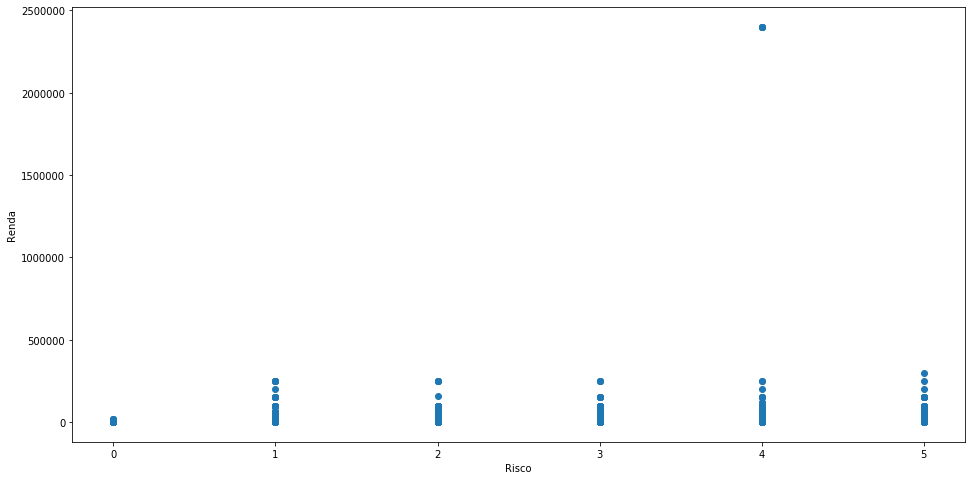

In [31]:
#Distribuição
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(dfPerfilAnaliseRendaRisco.Risco, dfPerfilAnaliseRendaRisco.RendaMensal)
ax.set_xlabel('Risco')
ax.set_ylabel('Renda')
plt.show()

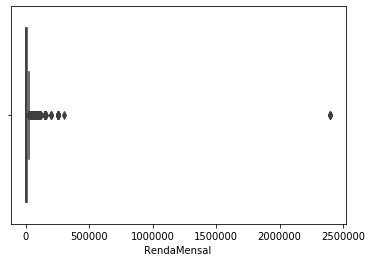

In [32]:
#Outliers no dataset de renda
sns.boxplot(x=dfPerfilAnaliseRendaRisco.RendaMensal)

In [33]:
#Remoção dos outliers
removeOutlierByQuartiles(dfPerfilAnaliseRendaRisco, 'RendaMensal')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6e0bb9310>,
      dtype=object)

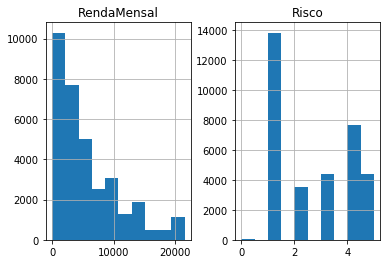

In [34]:
dfPerfilAnaliseRendaRisco.hist()

### Conclusão
Há grande concentração de salário até 5 mil reais e distribuição equilibrada entre perfil 1, 4 e 5. Desta maneira, não importa o salário para delimitar o perfil de invetidor

## É possível criar Clurteres de investimentor?

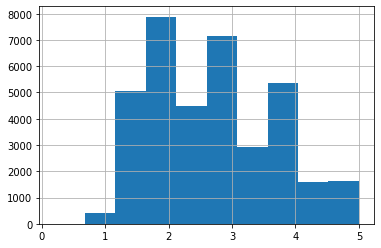

In [35]:
#Junção de DFs de interesse
join = pd.merge(dfPerfil, dfProduto[['ProdutoId', 'NomeProduto__c']], left_on='Produto', right_on='ProdutoId', how='inner')

#Gerando DataSet Perfil com apenas as variáveis que indicariam alguma classificação
dfPerfilInteresse = pd.DataFrame(
      {
          'PerfilInvestidor': join['PerfilInvestidor']
          , 'ScoreNivelConhecimento': join['ScoreNivelConhecimento']
          , 'ScoreRisco': join['ScoreRisco']
          , 'ScoreObjetivos': join['ScoreObjetivos']
          , 'ScoreSituacaoFinanceira': join['ScoreSituacaoFinanceira']
          #, 'RendaMensal': dfPerfil['RendaMensal'] #Ainda há dúvidas se é utlizável
          #, 'ProdutoID': join['NomeDoProduto']                  
          #, 'ProdutoID': join['NomeProduto__c']       
      })

dfPerfilInteresse['Cluster'] = dfPerfilInteresse.sum(axis=1) / 5
dfPerfilInteresse['Cluster'].hist()

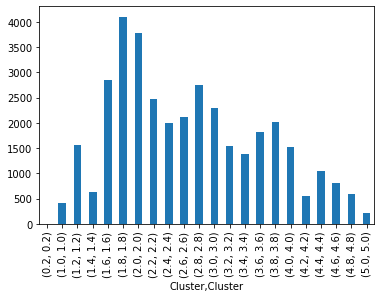

In [36]:
groups = dfPerfilInteresse.groupby('Cluster')['Cluster'].value_counts()
groups.plot.bar()

# Modelos

## Clusterização dos investimentos

In [6]:
dfProdutoFiltrado = dfProduto

#Filtro apenas de produtos ativos
#dfProdutoFiltrado = dfProdutoFiltrado[dfProdutoFiltrado['AtivoDisponivel__c'] == True]

#Entendendo o dado
dfProdutoFiltrado.describe()

,Unnamed: 0,DescontoIR__c,DiasVencimento__c,FiltroValorMinimo__c,LucroMesAnterior__c,NDiasCotizacaoAplicacao__c,NrDiasUteisCotizacaoResgate__c,NrDiasUteisLiqFAplicacao__c,NrDiasUteisLiqFResgate__c,PatrimonioLiquidoAtual__c,...,TaxaEmissao__c,TaxaNegociada360__c,TaxaPerformance__c,TaxaPreCliente__c,TaxaPreEmissao__c,Taxa__c,ValorMinimoAplicacaoAdicional__c,ValorMinimoAplicaInicial__c,ValorMinimoResgate__c,ValorMinimo__c
count,8603.000000,8603.000000,8282.000000,8603.000000,320.000000,320.000000,320.000000,320.0,320.000000,3.200000e+02,...,8282.000000,8282.0,0.0,8282.000000,8282.000000,8282.0,320.000000,320.000000,320.000000,8282.000000
mean,4301.000000,17.279437,858.665902,5781.588051,1.890720,0.390625,22.121875,0.0,1.540625,5.894390e+08,...,37.163605,0.0,NaN,5.104583,5.389063,0.0,2607.675000,6775.468750,2435.800000,5743.884569
std,2483.616516,2.606157,570.948565,11837.216847,18.521884,0.488655,17.729794,0.0,0.720223,1.209156e+09,...,49.820761,0.0,NaN,4.026771,11.667128,0.0,3616.864216,8598.930445,3155.308798,11944.003587
min,0.000000,15.000000,-1.000000,0.000000,-18.366811,0.000000,0.000000,0.0,0.000000,0.000000e+00,...,0.000000,0.0,NaN,0.000000,0.000000,0.0,0.000000,30.000000,0.000000,1.000000
25%,2150.500000,15.000000,361.000000,1000.000000,0.054150,0.000000,3.000000,0.0,1.000000,6.793882e+07,...,0.000000,0.0,NaN,3.150000,3.350000,0.0,500.000000,1000.000000,500.000000,1000.000000
50%,4301.000000,17.500000,719.000000,5000.000000,0.476561,0.000000,30.000000,0.0,1.000000,2.025237e+08,...,0.000000,0.0,NaN,5.700000,5.900000,0.0,1000.000000,5000.000000,1000.000000,5000.000000
75%,6451.500000,20.000000,1249.000000,10000.000000,1.345336,1.000000,30.000000,0.0,2.000000,6.523775e+08,...,100.000000,0.0,NaN,7.007500,7.197500,0.0,5000.000000,10000.000000,5000.000000,10000.000000
max,8602.000000,22.500000,17898.000000,1000000.000000,328.808151,1.000000,90.000000,0.0,5.000000,1.404355e+10,...,143.000000,0.0,NaN,114.000000,1000.000000,0.0,30000.000000,50000.000000,25000.000000,1000000.000000


In [30]:
dfProdutoFiltrado.head()

,Unnamed: 0,AdministradorFundo__c,AtivoDisponivel__c,Carencia__c,CarteiraCNPJ__c,CNPJAdministrador__c,DataDeVencimento__c,DescontoIR__c,DescricaoAtivo__c,DescricaoCarencia__c,...,TipoCarteira__c,TipoCota__c,TipoIndexador__c,TipoRegimeCondomonioCVM__c,Tributacao__c,ValorMinimoAplicacaoAdicional__c,ValorMinimoAplicaInicial__c,ValorMinimoResgate__c,ValorMinimo__c,Vencimento__c
0,0,NaN,False,2020-11-16,NaN,NaN,2020-11-16,20.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2020-11-16
1,1,NaN,False,2021-11-16,NaN,NaN,2021-11-16,17.5,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2021-11-16
2,2,NaN,False,2022-11-16,NaN,NaN,2022-11-16,15.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2022-11-16
3,3,NaN,False,2024-11-18,NaN,NaN,2024-11-18,15.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2024-11-18
4,4,NaN,False,2020-11-03,NaN,NaN,2020-11-03,20.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,...,NaN,NaN,Pré fixado,NaN,NaN,NaN,NaN,NaN,5000.0,2020-11-03


In [18]:
#Verificando dostribuição para geração de cluster
dfProdutoCluster = dfProdutoFiltrado[['ValorMinimoAplicaInicial__c', 'LucroMesAnterior__c', 'DescontoIR__c', 'NrDiasUteisCotizacaoResgate__c', 'NrDiasUteisLiqFResgate__c', 'DescontoIR__c']].fillna(0)

In [19]:
dfProdutoCluster.describe()

,ValorMinimoAplicaInicial__c,LucroMesAnterior__c,DescontoIR__c,NrDiasUteisCotizacaoResgate__c,NrDiasUteisLiqFResgate__c,DescontoIR__c
count,8603.000000,8603.000000,8603.000000,8603.000000,8603.000000,8603.000000
mean,252.022550,0.070328,17.279437,0.822852,0.057306,17.279437
std,2094.355902,3.584720,2.606157,5.402343,0.322876,2.606157
min,0.000000,-18.366811,15.000000,0.000000,0.000000,15.000000
25%,0.000000,0.000000,15.000000,0.000000,0.000000,15.000000
50%,0.000000,0.000000,17.500000,0.000000,0.000000,17.500000
75%,0.000000,0.000000,20.000000,0.000000,0.000000,20.000000
max,50000.000000,328.808151,22.500000,90.000000,5.000000,22.500000


Text(0.5, 1.0, 'Distribuição investimento')

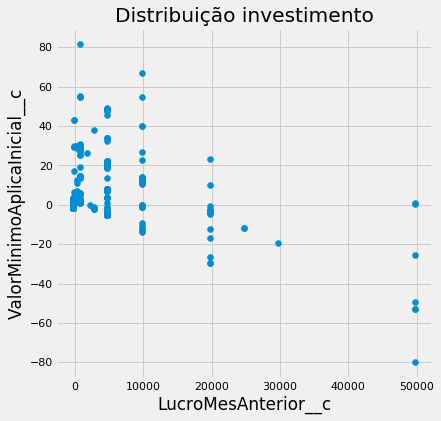

In [21]:
#Removendo outliers que quebram a análise (lucro > 15 e lucro < -15), são totalmente discrepantes em relação aos dados
#dfProdutoCluster.drop(dfProdutoCluster[dfProdutoCluster['LucroMesAnterior__c'] > 15].index, inplace = True)
#dfProdutoCluster.drop(dfProdutoCluster[dfProdutoCluster['LucroMesAnterior__c'] < -15].index, inplace = True)

pca = PCA(n_components=2).fit(dfProdutoCluster)
dfProdutoClusterReduzido = pca.transform(dfProdutoCluster)

#plot distribuição
plt.figure(figsize=(6,6))
plt.scatter(dfProdutoClusterReduzido[:,0], dfProdutoClusterReduzido[0:,1])
plt.xlabel('LucroMesAnterior__c')
plt.ylabel('ValorMinimoAplicaInicial__c')
plt.title('Distribuição investimento')

In [23]:
#Gerando clusters de investimento
#x_std = StandardScaler().fit_transform(dfProdutoCluster)
kmeans = KMeans(n_clusters=5, max_iter=100)
kmeans.fit(dfProdutoClusterReduzido)
centroids = km.cluster_centers_

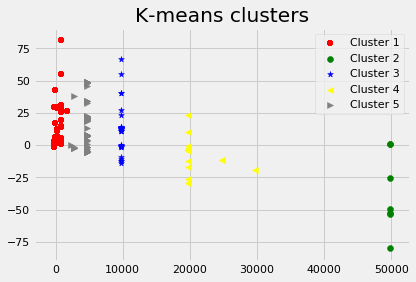

In [33]:
for i in range(0, dfProdutoClusterReduzido.shape[0]):
    if kmeans.labels_[i] == 0:
        c1 = plt.scatter(dfProdutoClusterReduzido[i,0],dfProdutoClusterReduzido[i,1],color='red',
        marker='+')
    elif kmeans.labels_[i] == 1:
        c2 = plt.scatter(dfProdutoClusterReduzido[i,0],dfProdutoClusterReduzido[i,1],color='green', 
        marker='o')
    elif kmeans.labels_[i] == 2:
        c3 = plt.scatter(dfProdutoClusterReduzido[i,0],dfProdutoClusterReduzido[i,1],color='blue',
        marker='*')
    elif kmeans.labels_[i] == 3:
        c4 = plt.scatter(dfProdutoClusterReduzido[i,0],dfProdutoClusterReduzido[i,1],color='yellow',
        marker='<')
    elif kmeans.labels_[i] == 4:
        c5 = plt.scatter(dfProdutoClusterReduzido[i,0],dfProdutoClusterReduzido[i,1],color='grey',
        marker='>')
        
plt.legend([c1, c2, c3, c4, c5],['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])
plt.title('K-means clusters')
plt.show()

## Modelo classificador -> Codinome: Xuxa Recomendation

A ideia desse sistema de recomendação é:


* A partir dos dados de Score (conhecimento, risco, objetivos, situacao financeira) e perfil investidor, determinar o melhor produto

O mapa do modelo é representado abaxo:

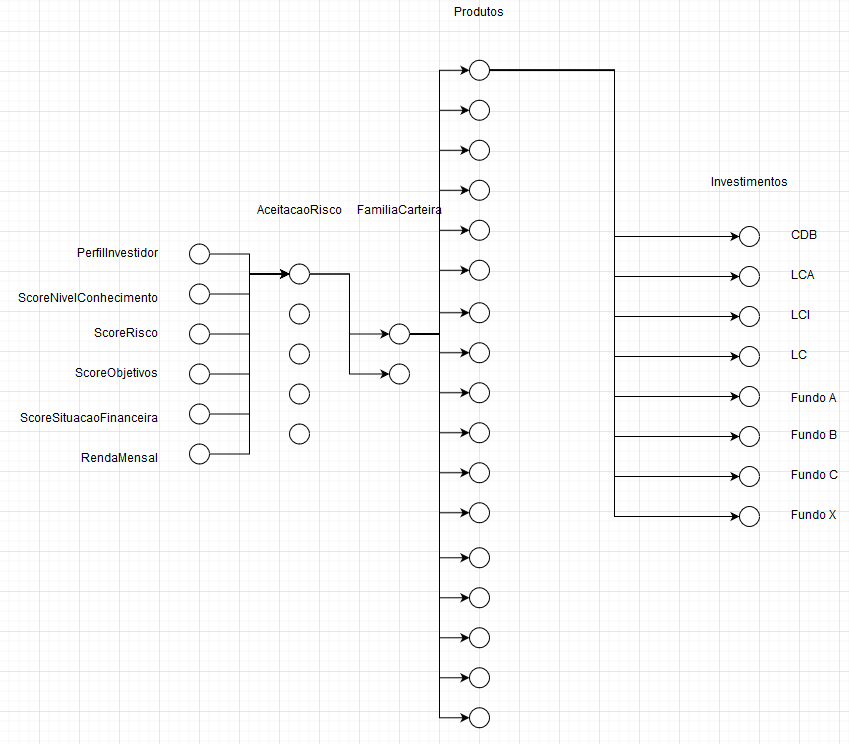

### Setup
Coleta e limpeza de dados de interesse

#### Selecionando variáveis - DataSet Perfil

In [37]:
#Método que verifica registro duplicado por ID no DataSet
#Isso significa quea coluna 'Unnamed: 0' é o ID identificador do investimento para o usuário X que possui identificação  pela coluna 'Id'
pd.concat(g for _, g in dfPerfil.groupby('Id') if len(g) > 1).head(5)

,Unnamed: 0,Id,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,...,ValorMinimoAplicacaoAdicional,DataVencimento,FamiliaCarteira,ValorInvestidoAtual,ValorRendimento,Rentabilidade12Meses,RentabilidadeMes,RiscoAtivo,Status,ProdutoId
18061,18061,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..Fx6NhsrK9ZzYadq...,35,C,Juiz de Fora,1.0,1.0,2,2000.0,15000.0,...,30.0,NaN,Renda Fixa,30.0,NaN,0.0,-0.51989985,4.0,Efetivada,a0W6A000009L0FgUAK
18062,18062,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..Fx6NhsrK9ZzYadq...,35,C,Juiz de Fora,1.0,1.0,2,2000.0,15000.0,...,30.0,NaN,Renda Fixa,30.0,NaN,0.0,0.18808109,1.0,Efetivada,a0W6A000009GZdgUAG
1512,1512,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./VfMzqzrDosESSEW...,57,C,Maringá,1.0,1.0,1,1950.0,300000.0,...,30.0,NaN,Renda Fixa,50.0,NaN,0.0,0.04210412,1.0,Efetivada,a0W6A000009GZdgUAG
1513,1513,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./VfMzqzrDosESSEW...,57,C,Maringá,1.0,1.0,1,1950.0,300000.0,...,30.0,NaN,Renda Fixa,30.0,NaN,0.0,0.0930036,1.0,Efetivada,a0W6A000009GZdgUAG
1514,1514,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./VfMzqzrDosESSEW...,57,C,Maringá,1.0,1.0,1,1950.0,300000.0,...,30.0,NaN,Renda Fixa,45.5,NaN,0.0,0.1883326,1.0,Efetivada,a0W6A000009GZdgUAG


In [78]:
join = pd.merge(dfPerfil, dfProduto[['ProdutoId', 'NomeProduto__c']], left_on='Produto', right_on='ProdutoId', how='inner')
join.describe()

,Unnamed: 0,Idade,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,TaxaCliente,TaxaPreCliente,ValorMinimoAplicaInicial,ValorMinimoAplicacaoAdicional,ValorInvestidoAtual,ValorRendimento,Rentabilidade12Meses,RiscoAtivo
count,36483.000000,36483.000000,33892.000000,36478.000000,36483.000000,3.648300e+04,2.480900e+04,36478.000000,36478.000000,36478.000000,5614.000000,5615.000000,22746.000000,30929.000000,36483.000000,5421.000000,30861.000000,36476.000000
mean,19187.806622,37.306170,2.504927,2.557350,2.835512,8.530422e+03,8.753467e+05,2.682466,3.156231,2.135314,98.189526,0.413389,744.188094,360.480540,4046.749768,196.936554,9.666901,2.615309
std,11051.177460,11.372435,1.526493,1.541056,1.080879,2.808069e+04,1.367181e+07,1.110293,1.177186,1.013575,26.149983,1.776756,2344.743320,1032.730307,17034.380766,748.580640,18.926591,1.532361
min,0.000000,17.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99.693346,0.000000
25%,9599.500000,29.000000,1.000000,1.000000,2.000000,2.000000e+03,4.000000e+04,2.000000,2.000000,1.000000,94.000000,0.000000,30.000000,30.000000,40.000000,7.490000,0.000000,1.000000
50%,19389.000000,36.000000,2.000000,2.000000,3.000000,4.500000e+03,2.000000e+05,3.000000,3.000000,2.000000,101.000000,0.000000,30.000000,30.000000,300.000000,28.080000,0.000000,2.000000
75%,28782.500000,43.000000,4.000000,4.000000,4.000000,1.000000e+04,7.000000e+05,3.000000,4.000000,3.000000,113.000000,0.000000,500.000000,100.000000,2000.000000,103.750000,11.122177,4.000000
max,38100.000000,96.000000,5.000000,5.000000,5.000000,2.400000e+06,1.500000e+09,5.000000,5.000000,5.000000,140.000000,12.000000,50000.000000,30000.000000,800000.000000,16834.210000,584.324863,5.000000


In [76]:
#Junção de DFs de interesse
join = pd.merge(dfPerfil, dfProduto[['ProdutoId', 'NomeProduto__c']], left_on='Produto', right_on='ProdutoId', how='inner')

#join = join[join['AtivoDisponivel__c'] == True]

dfProduto['AtivoDisponivel__c']

#Gerando DataSet Perfil com apenas as variáveis que indicariam alguma classificação
dfPerfilInteresse = pd.DataFrame(
      {
          'PerfilInvestidor': join['PerfilInvestidor']
          , 'ScoreNivelConhecimento': join['ScoreNivelConhecimento']
          , 'ScoreRisco': join['ScoreRisco']
          , 'ScoreObjetivos': join['ScoreObjetivos']
          , 'ScoreSituacaoFinanceira': join['ScoreSituacaoFinanceira']
          #, 'RendaMensal': dfPerfil['RendaMensal'] #Ainda há dúvidas se é utlizável
          , 'ProdutoID': join['NomeDoProduto']                  
          #, 'ProdutoID': join['NomeProduto__c']       
      })

In [40]:
#Descrevendo o novo data set de interesse
dfPerfilInteresse.describe()

,PerfilInvestidor,ScoreNivelConhecimento,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira
count,36483.000000,36478.000000,36478.000000,36478.000000,36478.000000
mean,2.835512,2.557350,2.682466,3.156231,2.135314
std,1.080879,1.541056,1.110293,1.177186,1.013575
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,2.000000
75%,4.000000,4.000000,3.000000,4.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


####Tratamendo do dataset de interesse

In [246]:
#Removendo os valores NaN
dfPerfilInteresse.dropna(inplace=True)

In [14]:
#DataSet equilibrado de acordo com o descrivo
dfPerfilInteresse.describe()

,PerfilInvestidor,ScoreNivelConhecimento,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira
count,36468.000000,36468.000000,36468.000000,36468.000000,36468.000000
mean,2.836542,2.557365,2.682708,3.156329,2.135379
std,1.079867,1.541173,1.110156,1.177198,1.013532
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,2.000000
75%,4.000000,4.000000,3.000000,4.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


In [42]:
#Verificando outliers das colunas PerfilInvestidos
#Previsto valores 1 a 5
dfPerfilInteresse.PerfilInvestidor.unique()

array([2, 1, 3, 4, 5, 0])

In [43]:
#Removendo valore com PerfilInvestido 0
#Esse perfil não está no app
dfPerfilInteresse.drop(index=dfPerfilInteresse[dfPerfilInteresse.PerfilInvestidor == 0].index, inplace=True)

In [44]:
#Verificando ScoreNivelConhecimento
dfPerfilInteresse.ScoreNivelConhecimento.unique()

array([ 1.,  4.,  2.,  5.,  3., nan])

In [45]:
#Verificando ScoreRisco
dfPerfilInteresse.ScoreRisco.unique()

array([ 2.,  3.,  4.,  1.,  5., nan])

In [46]:
#Verificando ScoreObjetivos
dfPerfilInteresse.ScoreObjetivos.unique()

array([ 2.,  3.,  1.,  5.,  4., nan])

In [47]:
#Verificando ScoreSituacaoFinanceira
dfPerfilInteresse.ScoreSituacaoFinanceira.unique()

array([ 1.,  2.,  3.,  5.,  4., nan])

In [48]:
#Verificando FamiliaCarteira
dfPerfilInteresse.ProdutoID.isna().sum()

0

#### Balanceamento do DataSet

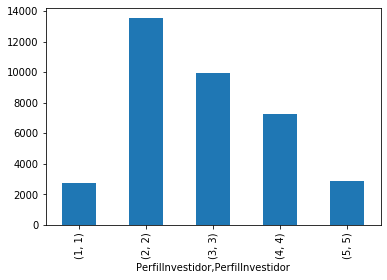

In [49]:
groups = dfPerfilInteresse.groupby('PerfilInvestidor')['PerfilInvestidor'].value_counts()
groups.plot.bar()

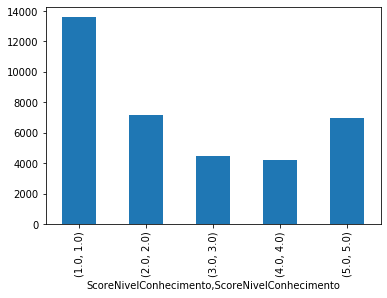

In [50]:
groups = dfPerfilInteresse.groupby('ScoreNivelConhecimento')['ScoreNivelConhecimento'].value_counts()
groups.plot.bar()

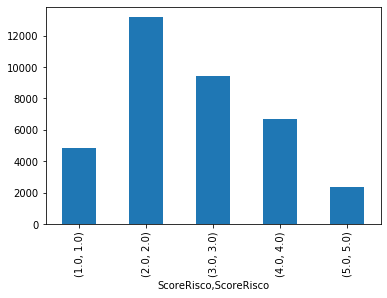

In [51]:
groups = dfPerfilInteresse.groupby('ScoreRisco')['ScoreRisco'].value_counts()
groups.plot.bar()

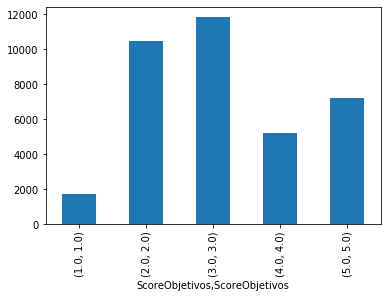

In [52]:
groups = dfPerfilInteresse.groupby('ScoreObjetivos')['ScoreObjetivos'].value_counts()
groups.plot.bar()

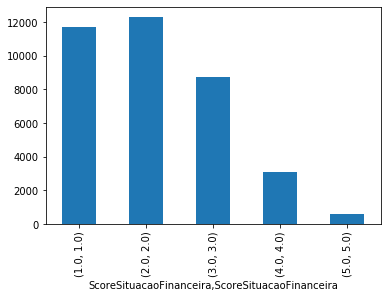

In [53]:
groups = dfPerfilInteresse.groupby('ScoreSituacaoFinanceira')['ScoreSituacaoFinanceira'].value_counts()
groups.plot.bar()

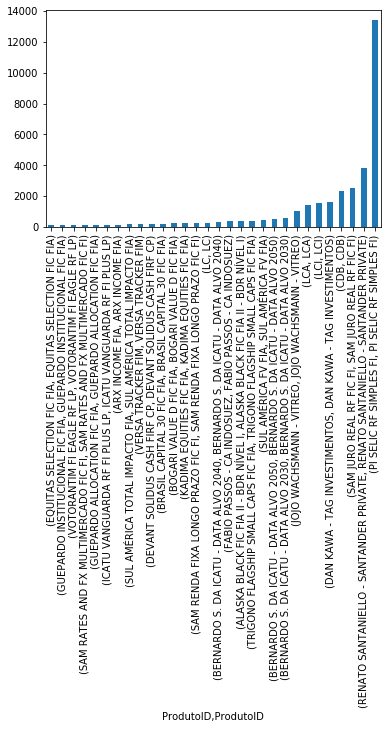

In [55]:
groups = dfPerfilInteresse.groupby('ProdutoID')['ProdutoID'].value_counts().sort_values().tail(30)
groups.plot.bar()
#Amostra de dados totalmente desbalanceada. Os pesos serão inseridos no momento de treinar

#### Preparando dataset para o modelo - 1.0

In [56]:
#Configurando variáveis categóricas
familiaCarteira = {'Renda Fixa': 0, 'Renda Variável': 1}
dfModelo = dfPerfilInteresse.copy()

#Transformando produtos em One Hot Encoded
dict_produtos = pd.DataFrame(dfModelo.ProdutoID.apply(lambda produto: produto.lower()).unique()).to_dict()[0]
dict_produto_one_hot_enconded = {}
productsEncoded = tf.keras.utils.to_categorical(np.array(list(dict_produtos.keys())), len(dict_produtos))
for dictProdutoKey in dict_produtos.keys():
  dict_produto_one_hot_enconded[dictProdutoKey] = productsEncoded[dictProdutoKey]

#dfModelo.ProdutoID = dfModelo.ProdutoID.apply(lambda produto: getOneHotEncodedByProdutcName(dict_produtos, dict_produto_one_hot_enconded, produto))
dfModelo.ProdutoID = dfModelo.ProdutoID.apply(lambda produto: getProdutoId(dict_produtos, produto))

#Testes
dfModelo.PerfilInvestidor = dfModelo.PerfilInvestidor / 255
dfModelo.ScoreNivelConhecimento = dfModelo.ScoreNivelConhecimento / 255
dfModelo.ScoreRisco = dfModelo.ScoreRisco / 255
dfModelo.ScoreObjetivos = dfModelo.ScoreObjetivos / 255
dfModelo.ScoreSituacaoFinanceira = dfModelo.ScoreSituacaoFinanceira / 255

#Separando Treino e teste
msk = np.random.rand(len(dfModelo)) < 0.7

df_treino = dfModelo[msk]
df_teste  =  dfModelo[~msk]

x_train = df_treino.loc[:, df_treino.columns != 'ProdutoID']
y_train = df_treino['ProdutoID']
x_test = df_teste.loc[:, df_teste.columns != 'ProdutoID']
y_test = df_teste['ProdutoID']

#Balanceando os investimentos
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

#### Desenhando o modelo

In [61]:
#Desenhando o modelo 1.0
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train.shape[1], name='perfil'), #Entradas
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='relu', name='aceitacao'), #Aceitaao (1 a 5)
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='relu', name='familia_carteira'), #FamiliaCarteira (Renda Fixa e Renda Variavel) 
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(17, activation='relu', name='tipo_produto'), #TipoProduto (17 produtos)
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(dict_produtos), activation='softmax', name='investimentos'), #Investimentos
], name='xuxa_model')

opt = tf.keras.optimizers.Adadelta(learning_rate=0.0001)
#1 'sparse_categorical_crossentropy'
#lss = tf.keras.losses.kld
lss = tf.keras.losses.sparse_categorical_crossentropy

model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

#Remover os logs do TensorBoard
removeHistory = False

#Nome do arquivo de treinamento
trainingName = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + "Adamax"

if (removeHistory):
    !rm -rf ./logs/ 

#Configurando o callback do TensorBoard
log_dir = "logs/fit/" + trainingName
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.summary()

Model: "xuxa_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
aceitacao (Dense)            (None, 5)                 30        
_________________________________________________________________
familia_carteira (Dense)     (None, 2)                 12        
_________________________________________________________________
tipo_produto (Dense)         (None, 17)                51        
_________________________________________________________________
investimentos (Dense)        (None, 243)               4374      
Total params: 4,467
Trainable params: 4,467
Non-trainable params: 0
_________________________________________________________________


#### Treinamento

Ao treinar é possível verificar o andamento pelo TensorBoard que encontra-se no notebook nesse mesmo path

In [206]:
# Treinamento do modelo
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    epochs=20000, 
    batch_size=1024, 
    shuffle=True, 
    callbacks=[tensorboard_callback], 
    verbose=False,
    class_weight=class_weights
)

#### Qualidade do modelo

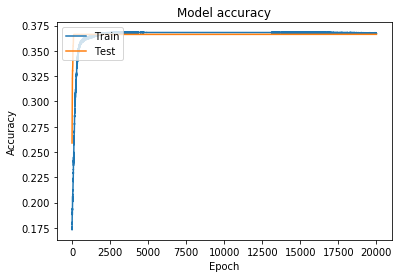

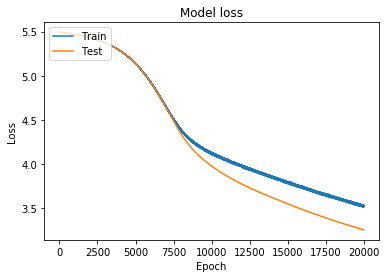

In [207]:
#Avaliando treinamento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

####Teste manual

In [210]:
#Pos1 = PerfilInvestidor (1 a 5)
pos1 = 3
#Pos2 = ScoreConhecimento (1 a 5)
pos2 = 3
#Pos3 = ScoreRisco (1 a 5)
pos3 = 3
#Pos4 =\ScoreObjetivos (1 a 5)
pos4 = 3
#Pos5 = ScoreSituacaoFinanceira (1 a 5)
pos5 = 3

inputData = [[pos1, pos2, pos3, pos4, pos5]]

#inputDados['pos1'] = pos1
#inputDados['pos2'] = pos2
#inputDados['pos3'] = pos3
#inputDados['pos4'] = pos4
#inputDados['pos5'] = pos5

#TratamentoDadps
fixedData = pd.DataFrame(inputData) / 255

#Predizendo top 10 investimentos
modelResult = model.predict(fixedData)

#Filtrando apenas resultados relevantes (top 10)
modelResultFixed = pd.DataFrame(modelResult)
modelResultFixed = modelResultFixed.transpose()[0]
investments = pd.DataFrame()
investments['Investimentos'] = modelResultFixed * 100
investments = investments.sort_values(by=['Investimentos'], ascending=False)
investments.head(10)

,Investimentos
0,24.040380
3,5.074982
2,3.862631
8,2.249092
12,1.822492
6,1.699976
9,1.571430
1,0.964332
7,0.840293
10,0.786626


In [111]:
dict_produtos

{0: 'pi selic rf simples fi',
 1: 'jojo wachsmann - vitreo',
 2: 'sam juro real rf fic fi',
 3: 'renato santaniello - santander private',
 4: 'sam renda fixa longo prazo fic fi',
 5: 'fabio passos - ca indosuez',
 6: 'dan kawa - tag investimentos',
 7: 'bernardo s. da icatu - data alvo 2030',
 8: 'cdb',
 9: 'lca',
 10: 'trigono flagship small caps fic fia',
 11: 'bogari value d fic fia',
 12: 'lci',
 13: 'bernardo s. da icatu - data alvo 2040',
 14: 'btg pactual yield di fi referenciado cp',
 15: 'alaska black fic fia ii - bdr nível i',
 16: 'icatu vanguarda cp firf lp',
 17: 'sam rates and fx multimercado fic fi',
 18: 'sul américa fv fia',
 19: 'lc',
 20: 'nest fia',
 21: 'kadima equities fic fia',
 22: 'constância fundamento fia',
 23: 'bernardo s. da icatu - data alvo 2050',
 24: 'arx income fia',
 25: 'equitas selection fic fia',
 26: 'equitas selection mão amiga fic ações',
 27: 'az quest yield fic firf lp',
 28: 'arx fia',
 29: 'ibiuna equities 30 fic fia',
 30: 'kapitalo kappa 